In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install Datasets

Note: you may need to restart the kernel to use updated packages.


In [19]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os, sys
import json
from datasets import load_dataset

In [6]:
ds = load_dataset("pantelism/cats-vs-dogs", split = "train")

dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [7]:
images = ds['image']
labels = [1 if label == 'dog' else 0 for label in ds['label']]

In [8]:
images_resized = np.array([np.array(image.resize((128, 128))) for image in images])
images_resized = images_resized.astype('float32') / 255.0
images_resized = (images_resized - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])

In [9]:
labels = np.array(labels)

In [10]:
model = models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s] 


In [11]:
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
images_tensor = torch.tensor(images_resized, dtype=torch.float32).permute(0, 3, 1, 2)
labels_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(images_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/2], Loss: 0.0058
Epoch [2/2], Loss: 0.0000


Integrated Gradients is a method that attributes the prediction of a deep learning model to its input features. It does this by integrating the gradients of the model's output with respect to the input along a straight path from a baseline input (usually all zeros) to the actual input.

### Steps:
1. Compute the gradients of the model's output with respect to the input.
2. Integrate these gradients along the path from the baseline to the input.
3. Scale the attributions based on the difference between the input and the baseline.

Let’s implement Integrated Gradients to visualize feature importance.

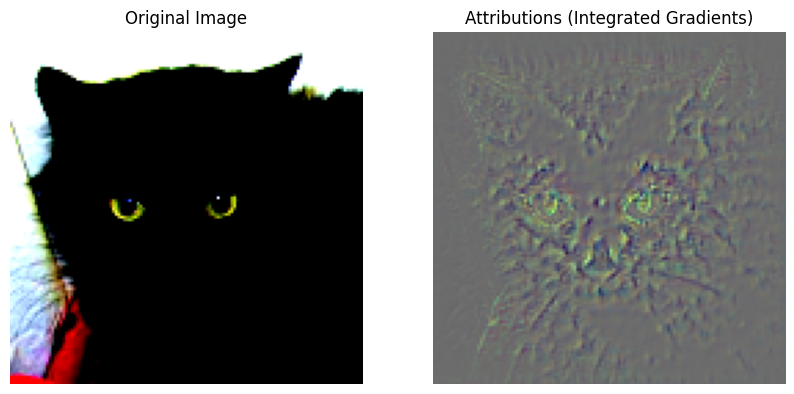

In [16]:
def compute_integrated_gradients(model, input_tensor, target_class):
    ig = IntegratedGradients(model)
    attr, delta = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)
    return attr, delta

sample_index = 0  
input_tensor = images_tensor[sample_index].unsqueeze(0)  
target_class = labels_tensor[sample_index].item()

attributions, delta = compute_integrated_gradients(model, input_tensor, target_class)

attr_numpy = attributions.squeeze().detach().numpy()
attr_numpy = np.transpose(attr_numpy, (1, 2, 0))
attr_numpy = (attr_numpy - np.min(attr_numpy)) / (np.max(attr_numpy) - np.min(attr_numpy))  # Normalize

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(input_tensor.squeeze().numpy(), (1, 2, 0)))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_numpy)
plt.title("Attributions (Integrated Gradients)")
plt.axis('off')

plt.show()

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique for visualizing the important regions in the input image for a given class. It uses the gradients of the output with respect to the feature maps of a convolutional layer to produce a coarse localization map.


### Steps:
1. Compute the gradients of the target class with respect to the feature maps.
2. Global average pool the gradients to obtain the weights.
3. Multiply the feature maps by the weights and apply a ReLU activation to get the heatmap.

Let’s implement Grad-CAM to visualize important regions in the image for classification.

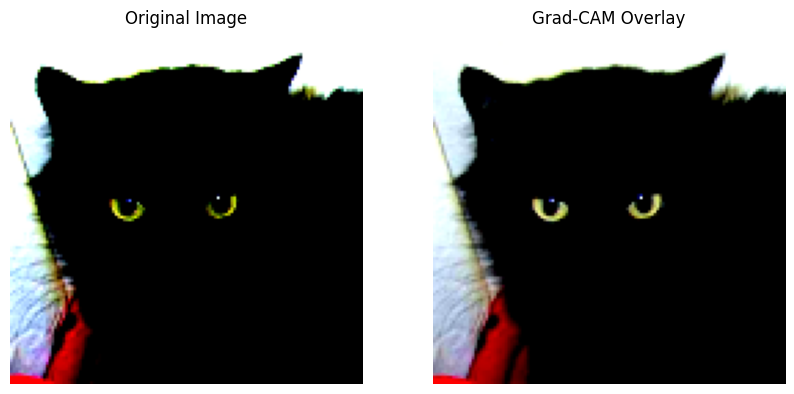

In [22]:
def compute_grad_cam(model, input_tensor, target_class):
    grad_cam = LayerGradCam(model, model.features)
    attributions = grad_cam.attribute(input_tensor, target=target_class)
    return attributions

grad_cam_attributions = compute_grad_cam(model, input_tensor, target_class)

grad_cam_numpy = grad_cam_attributions.squeeze().detach().numpy()
grad_cam_numpy = np.maximum(grad_cam_numpy, 0)  # ReLU to keep only positive values
grad_cam_numpy = grad_cam_numpy / np.max(grad_cam_numpy)  # Normalize

heatmap = cv2.resize(grad_cam_numpy, (128, 128))
heatmap = np.expand_dims(heatmap, axis=-1)

heatmap_rgb = cv2.merge([heatmap.squeeze(), heatmap.squeeze(), heatmap.squeeze()])  # Create a 3-channel heatmap

original_image = np.transpose(input_tensor.squeeze().numpy(), (1, 2, 0))
overlay = cv2.addWeighted(original_image, 0.5, heatmap_rgb, 0.5, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.show()

- **Integrated Gradients** provided insight into which pixels contributed most to the model's decision.
- **Grad-CAM** highlighted the specific regions in the image that influenced the classification outcome.